In [1]:
import data
import tf2lib as tl

import os
import numpy as np
import tensorflow as tf
import pydicom
import matplotlib.pyplot as plt

In [2]:
def load_dicom_series(folder_path):
    """
    Load DICOM series from a folder (multiple echoes per sample).
    
    Args:
        folder_path: str, path to folder containing DICOM files
        num_echoes: int, expected number of echoes (optional, for reshape)
        target_shape: tuple (H, W), desired image size (optional, for resize)
    
    Returns:
        np.ndarray of shape (num_echoes, H, W)
    """
    dicom_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path)
                          if f.endswith(".dcm")])
    
    images = []
    n_sl = 0
    err_flag = False
    for j, f in enumerate(dicom_files):
        ds = pydicom.dcmread(f)
        img = ds.pixel_array.astype(np.float32)

        img_comp = str(ds.get((0x2005, 0x1011), pydicom.DataElement((0x2005, 0x1011), 'DS', 1)).value)
        echo_time = float(ds.get((0x0018, 0x0081), pydicom.DataElement((0x0018, 0x0081), 'DS', 1)).value)
        echo_num = int(ds.get((0x0018, 0x0086), pydicom.DataElement((0x0018, 0x0086), 'DS', 1)).value)
        echo_all = int(ds.get((0x0018, 0x0091), pydicom.DataElement((0x0018, 0x0091), 'DS', 1)).value)
        RescaleIntercept = float(ds.get((0x2005, 0x100D), pydicom.DataElement((0x2005, 0x100D), 'DS', 1)).value)
        RescaleSlope = float(ds.get((0x2005, 0x100A), pydicom.DataElement((0x2005, 0x100A), 'DS', 1)).value)
        # print(j, "Component: ", img_comp)

        resc_img = RescaleSlope*(img-RescaleIntercept)

        if img_comp == "R" and echo_num == 1:
            err_flag = False
            echoes = list()

        if img_comp == "R":
            aux_img = np.expand_dims(resc_img,axis=-1)
        elif img_comp == "I":
            aux_img = np.concatenate([aux_img,np.expand_dims(resc_img,axis=-1)], axis=-1)
            if aux_img.shape[-1] == 2:
                echoes.append(aux_img)
            else:
                err_flag = True

            if echo_all == len(echoes) and (not err_flag):
                im_echoes = np.stack(echoes, axis=0)
                # Normalization considering max magnitude value
                mag_echoes = np.sqrt(np.sum(np.square(im_echoes),axis=-1,keepdims=True))
                im_echoes_norm = im_echoes/np.max(mag_echoes)
                # Masking considering magnitude threshold
                im_echoes_mean = np.mean(mag_echoes/np.max(mag_echoes),axis=0,keepdims=True)
                im_echoes_mask = np.repeat(im_echoes_mean>0.05,echo_all,axis=0)
                im_echoes_mask = np.repeat(im_echoes_mask,2,axis=-1)
                images.append(np.where(im_echoes_mask,im_echoes_norm,0.0))
                n_sl += 1

    # print("No. slices:", n_sl)
    # for i, arr in enumerate(images):
        # print(i, arr.shape, arr.dtype)
    images = np.stack(images, axis=0)  # (num_echoes, H, W, 2)

    # Quantitative maps
    # out_maps = np.ones([n_sl,3,images.shape[1],images.shape[2],2], dtype=np.float32)

    return images

def tf_load_dicom_series(folder_path):
    """
    Wrap load_dicom_series in tf.py_function for use in tf.data.Dataset.
    """
    def _load(path):
        path = path.numpy().decode("utf-8")
        arr = load_dicom_series(path)
        return arr

    data = tf.py_function(
        func=_load,
        inp=[folder_path],
        Tout=tf.float32
    )
    
    return data

In [3]:
root = "../AI-PDFF/data/"
folders = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
folders_mr = [os.path.join(f, os.listdir(f)[0]) for i, f in enumerate(folders) if os.path.join(f, os.listdir(f)[0])]
folders_cse = list()
for f in folders_mr:
    scan_files = os.listdir(f)
    cse_scan = [item for item in scan_files if "MECSE" in item]
    folders_cse.append(os.path.join(f,cse_scan[0]))
    

In [4]:
for i, x in enumerate(folders_cse):
    print(i,x)

0 ../AI-PDFF/data/BVH001\MR_20180404\MECSE_301_MECSE
1 ../AI-PDFF/data/BVH002\MR_20170705\MECSE_901_FATFRACTIONESTIMATION
2 ../AI-PDFF/data/BVH003\MR_20180103\MECSE_301_MECSE
3 ../AI-PDFF/data/BVH005\MR_20170531\MECSE_701_FATFRACTIONESTIMATION
4 ../AI-PDFF/data/BVH007\MR_20180314\MECSE_301_MECSE
5 ../AI-PDFF/data/BVH008\MR_20171218\MECSE_301_MECSE
6 ../AI-PDFF/data/BVH009\MR_20180207\MECSE_301_MECSE
7 ../AI-PDFF/data/BVH011\MR_20180813\MECSE_501_MECSE
8 ../AI-PDFF/data/BVH012\MR_20170315\MECSE_501_FATFRACTIONESTIMATION
9 ../AI-PDFF/data/BVH013\MR_20171122\MECSE_301_MECSE
10 ../AI-PDFF/data/BVH014\MR_20180420\MECSE_301_MECSE
11 ../AI-PDFF/data/BVH015\MR_20170320\MECSE_601_FATFRACTIONESTIMATION
12 ../AI-PDFF/data/BVH016\MR_20220823\MECSE_301_MECSE
13 ../AI-PDFF/data/BVH017\MR_20170705\MECSE_501_FATFRACTIONESTIMATION
14 ../AI-PDFF/data/BVH018\MR_20180124\MECSE_401_MECSE


In [5]:
dataset = tf.data.Dataset.from_tensor_slices(folders_cse[4:5])
dataset = dataset.map(lambda f: tf_load_dicom_series(f))
dataset = dataset.unbatch()

# Example batching
dataset = dataset.batch(1)

In [6]:
for A in dataset.skip(10).take(1):
    print(A.shape)  # (batch_size, num_echoes, H, W, 2)
    # print(B.shape)  # (batch_size, 3, H, W, 2)

(1, 12, 192, 192, 2)


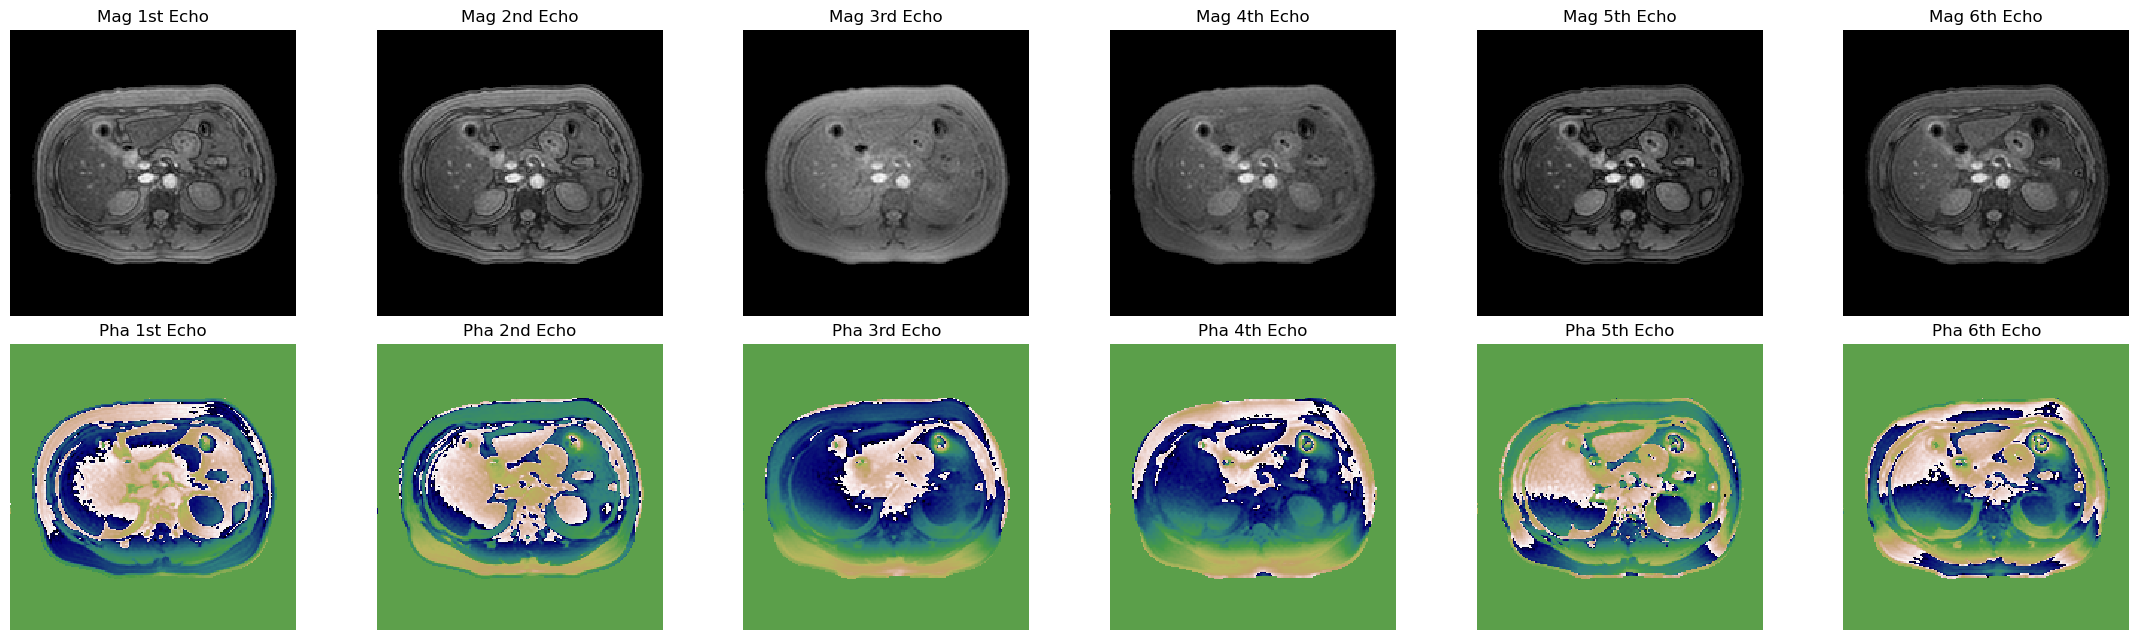

In [7]:
fig, axs = plt.subplots(figsize=(22, 6), nrows=2, ncols=6)

# Recon MR images at each echo
pha_ech1 = np.squeeze(np.arctan2(A[:,0,:,:,1],A[:,0,:,:,0]))
pha_ech2 = np.squeeze(np.arctan2(A[:,1,:,:,1],A[:,1,:,:,0]))
pha_ech3 = np.squeeze(np.arctan2(A[:,2,:,:,1],A[:,2,:,:,0]))
pha_ech4 = np.squeeze(np.arctan2(A[:,3,:,:,1],A[:,3,:,:,0]))
pha_ech5 = np.squeeze(np.arctan2(A[:,4,:,:,1],A[:,4,:,:,0]))
pha_ech6 = np.squeeze(np.arctan2(A[:,5,:,:,1],A[:,5,:,:,0]))

mag_ech1 = np.squeeze(np.abs(tf.complex(A[:,0,:,:,0],A[:,0,:,:,1])))
mag_ech2 = np.squeeze(np.abs(tf.complex(A[:,1,:,:,0],A[:,1,:,:,1])))
mag_ech3 = np.squeeze(np.abs(tf.complex(A[:,2,:,:,0],A[:,2,:,:,1])))
mag_ech4 = np.squeeze(np.abs(tf.complex(A[:,3,:,:,0],A[:,3,:,:,1])))
mag_ech5 = np.squeeze(np.abs(tf.complex(A[:,4,:,:,0],A[:,4,:,:,1])))
mag_ech6 = np.squeeze(np.abs(tf.complex(A[:,5,:,:,0],A[:,5,:,:,1])))

# Acquisitions in the first row
acqm_ech1 = axs[0,0].imshow(mag_ech1, cmap='gray',
                      interpolation='none', vmin=0, vmax=1)
axs[0,0].set_title('Mag 1st Echo')
axs[0,0].axis('off')
acqm_ech2 = axs[0,1].imshow(mag_ech2, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,1].set_title('Mag 2nd Echo')
axs[0,1].axis('off')
acqm_ech3 = axs[0,2].imshow(mag_ech3, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,2].set_title('Mag 3rd Echo')
axs[0,2].axis('off')
acqm_ech4 = axs[0,3].imshow(mag_ech4, cmap='gray',
                      interpolation='none', vmin=0, vmax=1)
axs[0,3].set_title('Mag 4th Echo')
axs[0,3].axis('off')
acqm_ech5 = axs[0,4].imshow(mag_ech5, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,4].set_title('Mag 5th Echo')
axs[0,4].axis('off')
acqm_ech6 = axs[0,5].imshow(mag_ech6, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,5].set_title('Mag 6th Echo')
axs[0,5].axis('off')


acqp_ech1 = axs[1,0].imshow(pha_ech1, cmap='gist_earth',
                      interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[1,0].set_title('Pha 1st Echo')
axs[1,0].axis('off')
acqp_ech2 = axs[1,1].imshow(pha_ech2, cmap='gist_earth',
                          interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[1,1].set_title('Pha 2nd Echo')
axs[1,1].axis('off')
acqp_ech3 = axs[1,2].imshow(pha_ech3, cmap='gist_earth',
                          interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[1,2].set_title('Pha 3rd Echo')
axs[1,2].axis('off')
acqp_ech4 = axs[1,3].imshow(pha_ech4, cmap='gist_earth',
                      interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[1,3].set_title('Pha 4th Echo')
axs[1,3].axis('off')
acqp_ech5 = axs[1,4].imshow(pha_ech5, cmap='gist_earth',
                          interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[1,4].set_title('Pha 5th Echo')
axs[1,4].axis('off')
acqp_ech6 = axs[1,5].imshow(pha_ech6, cmap='gist_earth',
                          interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[1,5].set_title('Pha 6th Echo')
axs[1,5].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
plt.show()